In [2]:
import keras as k
import keras.layers as l
from keras.models import load_model
import dataset_tools as dt

import random
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

import pylab as pl
from IPython import display

Using TensorFlow backend.


In [3]:
dataset_1 = '/mnt/data/deepfake/datasets/faces/Actor_01_aligned/'
dataset_2 = '/mnt/data/deepfake/datasets/faces/Actor_02_aligned/'

pics_a = dt.get_pics(dataset_1,-1)
pics_b = dt.get_pics(dataset_2,-1)

## Abstract root class

In [4]:
class df_net:    
    def __init__(self,pics_a, pics_b, ratio = 0.9, DIM = 100):
        self.DIM = DIM
        Xa, Xb = dt.format_images(pics_a, pics_b, DIM, DIM)
        self.train_a, self.test_a = dt.separate_dataset(Xa, ratio)
        self.train_b, self.test_b = dt.separate_dataset(Xb, ratio)
                
    def train(self, n_epochs = 1, verbose=0) :
        print("Epoch 0 / %d" % (n_epochs), end='\r')
        for n in range(n_epochs):
            hista = self.ae_a.fit(self.train_a, self.train_a, epochs=1, verbose=verbose)
            histb = self.ae_b.fit(self.train_b, self.train_b, epochs=1, verbose=verbose)
            print("Epoch %d / %d (loss_a = %f, loss_b = %f)                 "
                  % ((n+1),n_epochs,round(hista.history['loss'][0],4), round(histb.history['loss'][0],4)), end='\r')
            
    def save(self, folder) :
        os.makedirs(folder, exist_ok=True)
        self.ae_a.save(folder + "/ae_a.h5")
        self.ae_b.save(folder + "/ae_b.h5")
        
    def load(self, folder) :
        self.ae_a = load_model(folder + "/ae_a.h5")
        self.ae_b = load_model(folder + "/ae_b.h5")

## Dense networks

In [5]:
class dense_simple(df_net):
    def __init__(self,pics_a, pics_b):
        df_net.__init__(self, pics_a, pics_b)
        self.create_network()
        
    def create_network(self) :
        DIM = self.DIM
        input_layer = l.Input(shape = (DIM * DIM,))
        encoded = l.Dense(32, activation='relu')(input_layer)
        decoded_a = l.Dense(DIM*DIM, activation = "sigmoid")(encoded)
        decoded_b = l.Dense(DIM*DIM, activation = "sigmoid")(encoded)
        self.ae_a = k.Model(input_layer, decoded_a)
        self.ae_b = k.Model(input_layer, decoded_b)
        encodeur = k.Model(input_layer, encoded)
        
        self.ae_a.compile(optimizer='adadelta', loss='binary_crossentropy')
        self.ae_b.compile(optimizer='adadelta', loss='binary_crossentropy')

In [6]:
class dense_medium(df_net):
    def __init__(self,pics_a, pics_b):
        df_net.__init__(self, pics_a, pics_b)
        self.create_network()
        
    def create_network(self) :
        DIM = self.DIM
        input_layer = l.Input(shape = (DIM * DIM,))
        encoded = l.Dense(1024, activation='relu')(input_layer)
        encoded = l.Dense(64, activation='relu')(encoded)
        
        decoded_a = l.Dense(1024, activation = "sigmoid")(encoded)
        decoded_a = l.Dense(DIM*DIM, activation = "sigmoid")(decoded_a)
        
        decoded_b = l.Dense(1024, activation = "sigmoid")(encoded)
        decoded_b = l.Dense(DIM*DIM, activation = "sigmoid")(decoded_b)
        
        self.ae_a = k.Model(input_layer, decoded_a)
        self.ae_b = k.Model(input_layer, decoded_b)
        encodeur = k.Model(input_layer, encoded)
        
        self.ae_a.compile(optimizer='adadelta', loss='binary_crossentropy')
        self.ae_b.compile(optimizer='adadelta', loss='binary_crossentropy')

## CNN networks

In [7]:
class cnn_simple(df_net):
    def __init__(self,pics_a, pics_b, ratio = 0.9):
        df_net.__init__(self, pics_a, pics_b, ratio)
        
        #reshaping for CNN
        self.train_a = self.train_a.reshape((len(self.train_a), 100,100,1))
        self.train_b = self.train_b.reshape((len(self.train_b), 100,100,1))
        self.test_a = self.test_a.reshape((len(self.test_a), 100,100,1))
        self.test_b = self.test_b.reshape((len(self.test_b), 100,100,1))
        
        self.create_network()
        
    def create_network(self) :
        input_img = l.Input(shape=(self.DIM, self.DIM, 1))  # adapt this if using `channels_first` image data format

        x = l.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
        x = l.MaxPooling2D((2, 2), padding='same')(x)
        x = l.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = l.MaxPooling2D((2, 2), padding='same')(x)
        x = l.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        encoded = l.MaxPooling2D((2, 2), padding='same')(x)

        # at this point the representation is (4, 4, 8) i.e. 128-dimensional

        xa = l.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
        xa = l.UpSampling2D((2, 2))(xa)
        xa = l.Conv2D(8, (3, 3), activation='relu', padding='same')(xa)
        xa = l.UpSampling2D((2, 2))(xa)
        xa = l.Conv2D(16, (3, 3), activation='relu')(xa)
        xa = l.UpSampling2D((2, 2))(xa)
        decoded_a = l.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(xa)

        xb = l.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
        xb = l.UpSampling2D((2, 2))(xb)
        xb = l.Conv2D(8, (3, 3), activation='relu', padding='same')(xb)
        xb = l.UpSampling2D((2, 2))(xb)
        xb = l.Conv2D(16, (3, 3), activation='relu')(xb)
        xb = l.UpSampling2D((2, 2))(xb)
        decoded_b = l.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(xb)

        self.ae_a = k.Model(input_img, decoded_a)
        self.ae_b = k.Model(input_img, decoded_b)

        encoder = k.Model(input_img, encoded)

        self.ae_a.compile(optimizer='adadelta', loss='binary_crossentropy')
        self.ae_b.compile(optimizer='adadelta', loss='binary_crossentropy')

In [8]:
class cnn_medium(df_net):
    def __init__(self,pics_a, pics_b):
        df_net.__init__(self, pics_a, pics_b, 0.9, 104)
        
        #reshaping for CNN
        self.train_a = self.train_a.reshape((len(self.train_a), 104,104,1))
        self.train_b = self.train_b.reshape((len(self.train_b), 104,104,1))
        self.test_a = self.test_a.reshape((len(self.test_a), 104,104,1))
        self.test_b = self.test_b.reshape((len(self.test_b), 104,104,1))
        
        self.create_network()
        
    def create_network(self) :
        input_img = l.Input(shape=(self.DIM, self.DIM, 1))  # adapt this if using `channels_first` image data format

        
        
        
        x = l.Conv2D(16, (10, 10), activation='relu', padding='same')(input_img)
        x = l.MaxPooling2D((2, 2), padding='same')(x)
        x = l.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
        x = l.MaxPooling2D((2, 2), padding='same')(x)
        x = l.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
        x = l.MaxPooling2D((2, 2), padding='same')(x)
        x = l.Conv2D(8, (5, 5), activation='relu', padding='same')(x)
        encoded = l.MaxPooling2D((2, 2), padding='same')(x)

        # at this point the representation is (4, 4, 8) i.e. 128-dimensional

        xa = l.Conv2D(8, (5, 5), activation='relu', padding='same')(encoded)
        xa = l.UpSampling2D((2, 2))(xa)
        xa = l.Conv2D(8, (5, 5), activation='relu', padding='same')(xa)
        xa = l.UpSampling2D((2, 2))(xa)
        xa = l.Conv2D(8, (5, 5), activation='relu', padding='same')(xa)
        xa = l.UpSampling2D((2, 2))(xa)
        xa = l.Conv2D(16, (5, 5), activation='relu')(xa)
        xa = l.UpSampling2D((2, 2))(xa)
        decoded_a = l.Conv2D(1, (10, 10), activation='sigmoid', padding='same')(xa)

        xb = l.Conv2D(8, (5, 5), activation='relu', padding='same')(encoded)
        xb = l.UpSampling2D((2, 2))(xb)
        xb = l.Conv2D(8, (5, 5), activation='relu', padding='same')(xb)
        xb = l.UpSampling2D((2, 2))(xb)
        xb = l.Conv2D(8, (5, 5), activation='relu', padding='same')(xb)
        xb = l.UpSampling2D((2, 2))(xb)
        xb = l.Conv2D(16, (5, 5), activation='relu')(xb)
        xb = l.UpSampling2D((2, 2))(xb)
        decoded_b = l.Conv2D(1, (10, 10), activation='sigmoid', padding='same')(xb)

        self.ae_a = k.Model(input_img, decoded_a)
        self.ae_b = k.Model(input_img, decoded_b)

        encoder = k.Model(input_img, encoded)

        self.ae_a.compile(optimizer='adadelta', loss='binary_crossentropy')
        self.ae_b.compile(optimizer='adadelta', loss='binary_crossentropy')

# Display functions

In [16]:
def gen_fake_cnn(df_cnn, dim, count):
    for i in range(1,count+1):
        plt.subplot(3,count,i)
        test_img = df_cnn.test_b[i]
        fig = plt.imshow(test_img.reshape(dim,dim), cmap='gray')
        
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

    for i in range(1,count+1):
        plt.subplot(3,count,i+count)
        test_img = df_cnn.test_b[i]
        pred = df_cnn.ae_b.predict(test_img.reshape(1,dim,dim,1))
        fig = plt.imshow(pred.reshape(dim,dim), cmap='gray')
        
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
    for i in range(1,count+1):
        plt.subplot(3,count,i+count*2)
        test_img = df_cnn.test_b[i]
        pred = df_cnn.ae_a.predict(test_img.reshape(1,dim,dim,1))
        fig = plt.imshow(pred.reshape(dim,dim), cmap='gray')
        
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

In [10]:
def gen_fake_dense(df_dense, dim, count):
    for i in range(1,count+1):
        plt.subplot(3,count,i)
        test_img = df_dense.test_a[i]
        fig = plt.imshow(test_img.reshape(dim,dim), cmap='gray')
        
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

    for i in range(1,count+1):
        plt.subplot(3,count,i+count)
        test_img = df_dense.test_a[i]
        pred = df_dense.ae_a.predict(np.array([test_img]))
        fig = plt.imshow(pred.reshape(100,100), cmap='gray')
        
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        
    for i in range(1,count+1):
        plt.subplot(3,count,i+count*2)
        test_img = df_dense.test_a[i]
        pred = df_dense.ae_b.predict(np.array([test_img]))
        fig = plt.imshow(pred.reshape(100,100), cmap='gray')
        
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

# Dense network test bench

In [10]:
df_dense = dense_medium(pics_a, pics_b)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
plt.figure(figsize=(20,8))

while(True):    
    gen_fake_dense(df_dense, 100, 7)
    
    #clear display
    display.clear_output(wait=True)
    display.display(pl.gcf())
        
    df_dense.train(10)

# CNN test bench

In [13]:
df_cnn = cnn_medium(pics_a, pics_b)
df_cnn.load("medium_cnn_aligned_full")

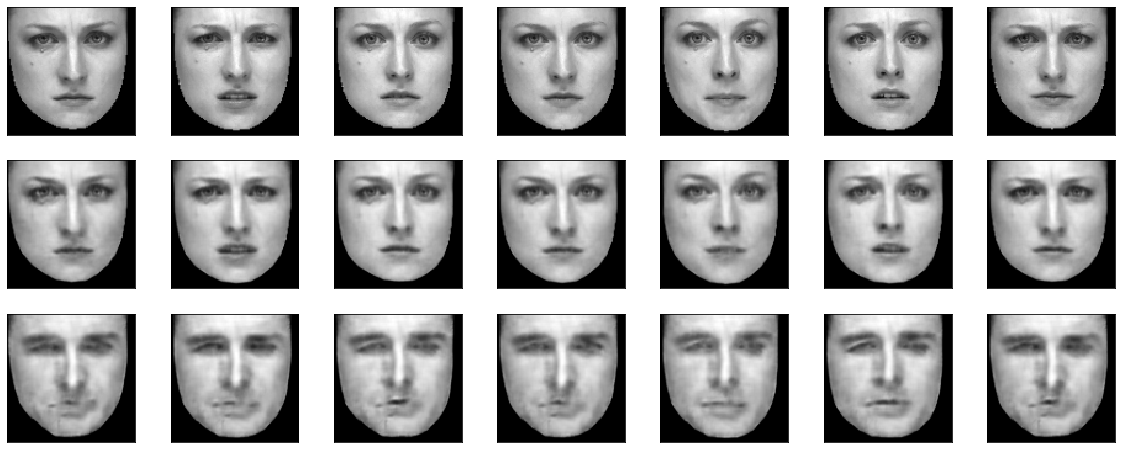

In [18]:
plt.figure(figsize=(20,8))
gen_fake_cnn(df_cnn, 104, 7)

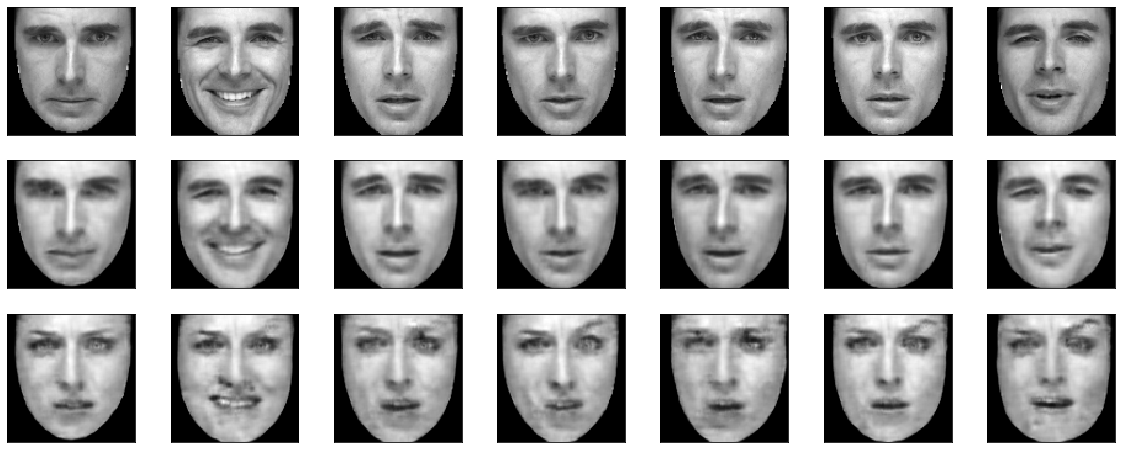

KeyboardInterrupt: 

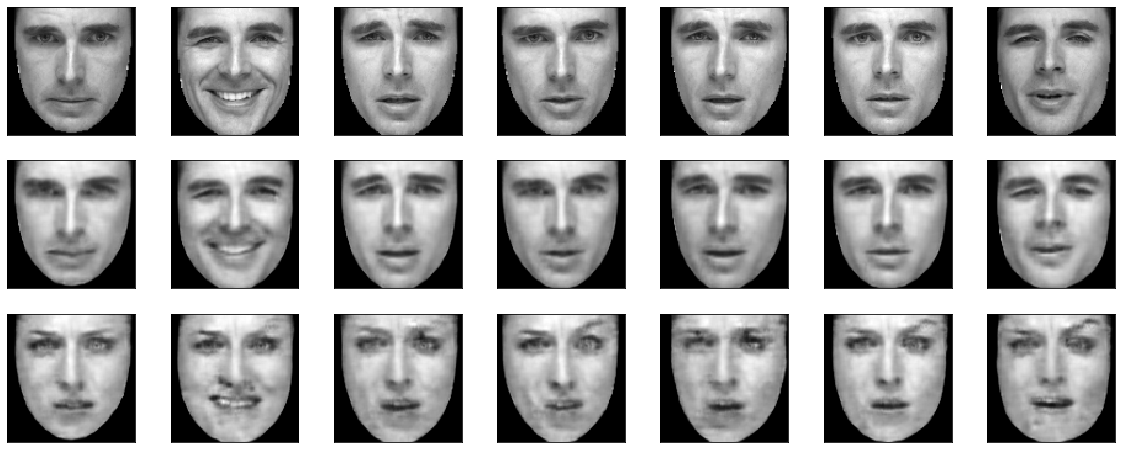

In [15]:
plt.figure(figsize=(20,8))

while(True):
    gen_fake_cnn(df_cnn, 104, 7)
    
    #clear display
    display.clear_output(wait=True)
    display.display(pl.gcf())
        
    df_cnn.train(10)
    df_cnn.save("medium_cnn_aligned_full")

In [ ]:
df_cnn.save("medium_cnn_aligned_full")